In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DecisionTree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()


y[::5] += 3 * (0.5 - rng.rand(16))

X_ = X.copy()
y_ = y.copy()


(80,)
(80,)


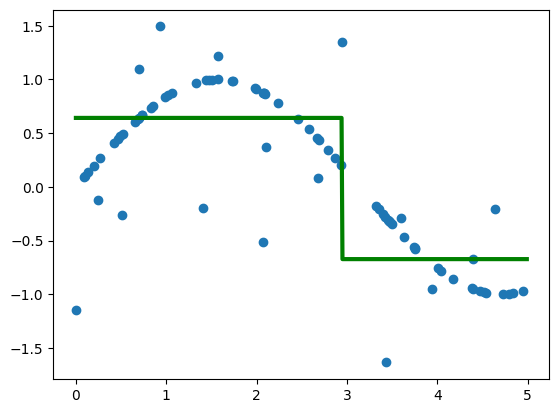

In [3]:
reg = DecisionTreeRegressor(max_depth=1, impurity="mae")
reg.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test = reg.predict(X_test)

plt.scatter(X, y)
plt.plot(X_test, y_test, color="green", linewidth=3)

print(y.shape)
print(y_.shape)

assert((X == X_).all())
assert((y == y_).all())


X.shape: (100, 2), y.shape: (100,)


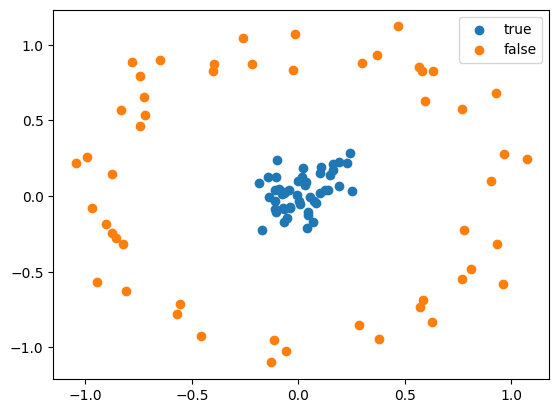

In [4]:
from sklearn.datasets import make_circles

X, y = make_circles(150, factor=0.1, noise=0.1, random_state=42)

X_test, y_test = X[100:], y[100:]
X, y = X[:100], y[:100]

print(f"X.shape: {X.shape}, y.shape: {y.shape}")

plt.scatter(X[y == 1, 0], X[y == 1, 1], label="true")
plt.scatter(X[y == 0, 0], X[y == 0, 1], label="false")
plt.legend()

In [9]:
from sklearn.metrics import accuracy_score

y[y==0] = -1
y_test[y_test==0] = -1

clf = DecisionTreeClassifier(max_depth=3, impurity="gini")
clf.fit(X_test, y_test)
pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, pred))

Classes: [1, -1]
Accuracy:  0.96


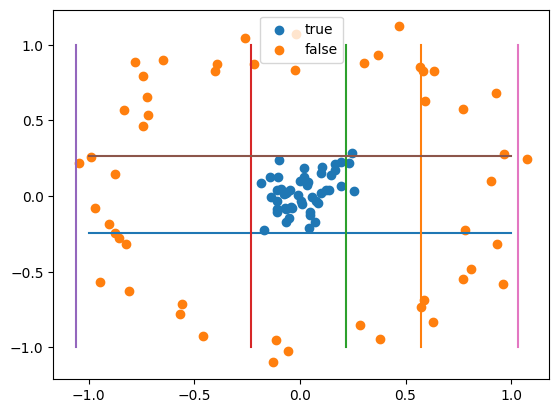

In [10]:
def plt_node(node):
    feat = "x" if node.j == 0 else "y"
    if feat == "x":
        plt.plot([node.t, node.t], [-1, 1])
    else:
        plt.plot([-1, 1], [node.t, node.t])
    node
    if node.is_leaf:
        return 
    plt_node(node.left)
    plt_node(node.right)

plt_node(clf.tree)   

plt.scatter(X[y == 1, 0], X[y == 1, 1], label="true")
plt.scatter(X[y == -1, 0], X[y == -1, 1], label="false")
plt.legend()